# Cat Vs Dog
---

<img src='images/Cat_Dog.jpg' width="50%" />

In this notebook I'm having a go at doing a Cat Vs Dog classifier using a pre-trained network with fine tuning.  The datasets themselves are going to sit in folders with paths:

    Cat_Dog_data/train/cat  (11250 files)
    Cat_Dog_data/train/dog  (11250 files)
    Cat_Dog_data/test/cat  (1250 files)
    Cat_Dog_data/test/dog  (1250 files) 
    
The files were sourced originally from Kaggle, but were downloaded from here [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip).  They are of different sizes and aspect ratios but typically no more than 500px in either direction.   Examples from the test set shown below.

<table  style="width:95%">
    <tr>
        <td><img src='images/catty_mc_catface.jpg' width="70%" /></td>
        <td><img src='images/doggy_mc_dogface.jpg' width="70%" /></td>   
    </tr>
    <tr>
        <td style="text-align: center">Catty Mc Catface</td>
        <td style="text-align: center">Doggy Mc Dogface</td>
    </tr>
</table>

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

I'll run this one on Colab, but may set it up on my laptop CPU first.

In [8]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available :(  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available :(  Training on CPU ...


In [9]:
import sys
import os.path 

IN_COLAB = 'google.colab' in sys.modules  #Checking if this is running in Colab

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    work_fold = '/content/drive/Cat_Vs_Dog/'
else:
    work_fold = os.path.dirname(os.path.realpath('__file__')) + '/' # I don't know why this doesn't work on Colab
    
print('Working directory: ', work_fold)

Working directory:  /home/olly/Desktop/Cat_Vs_Dog/


## Download from web source (if not done already)

Just getting this bit in place so I can use on Colab without having to download the images over slow internet.  It works, but it's not very pythonic just yet.  Will look into it once the cows have been fed.

In [14]:
# Subroutine to download and extract the data if needed
# import wget
import urllib

def Download_Images(working_directory, folder_name):
    
    zip_file_path = working_directory + folder_name + '.zip'
    #url = 'https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip'
    url = 'https://ollypowell.com/test_zip.zip'
    
    # Copy a network object to a local file
    #wget.download(url, zip_file_path)
    urllib.request.urlretrieve(url, folder_name + '.zip') # This puts zip file in the same parent directory as this code.

def Extract_Images(working_directory, folder_name):
    from zipfile import ZipFile
    zip_file_path = working_directory + folder_name + '.zip'
    destination_file_path = working_directory + folder_name + '/'
     
    with ZipFile(zip_file_path, 'r') as zip_object:
        zip_object.extractall(destination_file_path) # Extract to a folder
        print('Images extracted to: ', destination_file_path)
        os.remove(zip_file_path) #delete the zip file.


In [15]:
folder_name = 'test_zip'
path_to_folder = "{}/{}/".format(work_fold,folder_name)
path_to_zip = "{}/{}.zip".format(work_fold,folder_name)

if not os.path.isdir(path_to_folder):
    # Copy a network object to a local file
    if not os.path.isfile(path_to_zip):
        print("Images and zip file do not exist, images will be downloaded and extracted here")
        Download_Images(work_fold, folder_name)
        Extract_Images(work_fold, folder_name)
    else:
        print("Zip file already downloaded will be extracted here")
        Extract_Images(work_fold, folder_name)        
else:
    print ("Cat_Dog_data directory already loaded")

Cat_Dog_data directory already loaded


---
## Load the Data

The data is sitting in four seperate folders, for test, train, cat, dog

In [16]:
from torchvision import datasets as datasets
from torchvision import transforms as transforms
from torchvision import models as models
from torch.utils.data.sampler import SubsetRandomSampler

# This is from the transfer learning class exercise
# They use different tranforms for test and training folders.  
# The train folder needs to be re-stampled to split out a validation set

image_size = 224  # needs to be sized for the pre-trained network
input_mean = [ 0.485, 0.456, 0.406 ] # mean to be used for normalisation, matching that of the pre-trained images
input_std = [ 0.229, 0.224, 0.225 ] # stdev to be used for normalisation, matching that of the pre-trained images

# Transforms for the training data and testing data into a normalised torch float tensor
train_transforms = transforms.Compose([transforms.RandomRotation(degrees=45),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=.5),
                                      transforms.RandomVerticalFlip(p=0.05), # may want to give up on this one
                                      transforms.ToTensor(),
                                      transforms.Normalize(input_mean, input_std)])

test_transforms = transforms.Compose([transforms.Resize(image_size+30),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(input_mean, input_std)])

# convert for image display, it can be useful to un-normalise the tensor
inv_normalize = transforms.Normalize(
       mean = [-m/s for m, s in zip(input_mean, input_std)],
       std = [1/s for s in input_std])

In [17]:
# Split up the train dataset, and create the dataloaders.

num_workers = 0   # number of subprocesses to use for data loading
batch_size = 20   # how many samples per batch to load for each parameter update
valid_size = 0.2  #fraction of training dataset to split off for use as  validation
data_dir = 'Cat_Dog_data' #root directory for all the data

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_indices = list(range(len(train_data)))
np.random.shuffle(train_indices)
valid_sp = int(np.floor(valid_size * len(train_data)))  # The validation split size
valid_idx, train_idx  = train_indices[:valid_sp], train_indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(valid_idx))
print(' Test set size: \t', len(test_data))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle='true')

# specify the image classes 
#(because the data comes as 0 or 1 in the dataset, just based on order of the directories)
# Would be better to do this more generally using:  test_data.class_to_idx

classes = ['Cat', 'Dog']

 Training set size: 	 18000
 Validation set size: 	 4500
 Test set size: 	 2500


### Visualize a Batch of Training Data

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image

def imshow(img):
    img = inv_normalize(img)  # unnormalize the tensor 
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image to numpy

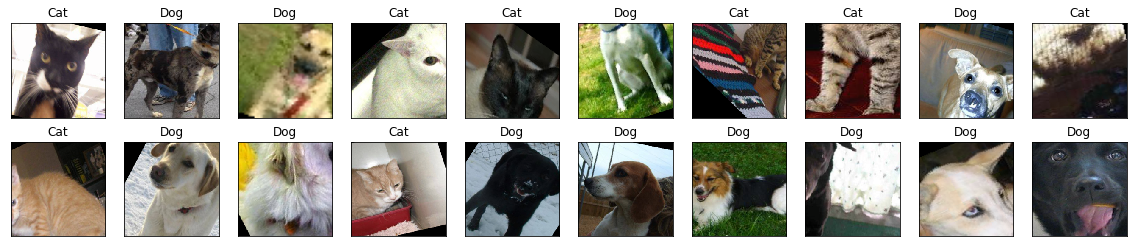

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()  # There is a problem with this line
  
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display one batch of images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])  # may need batch_size//2 for larger 
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

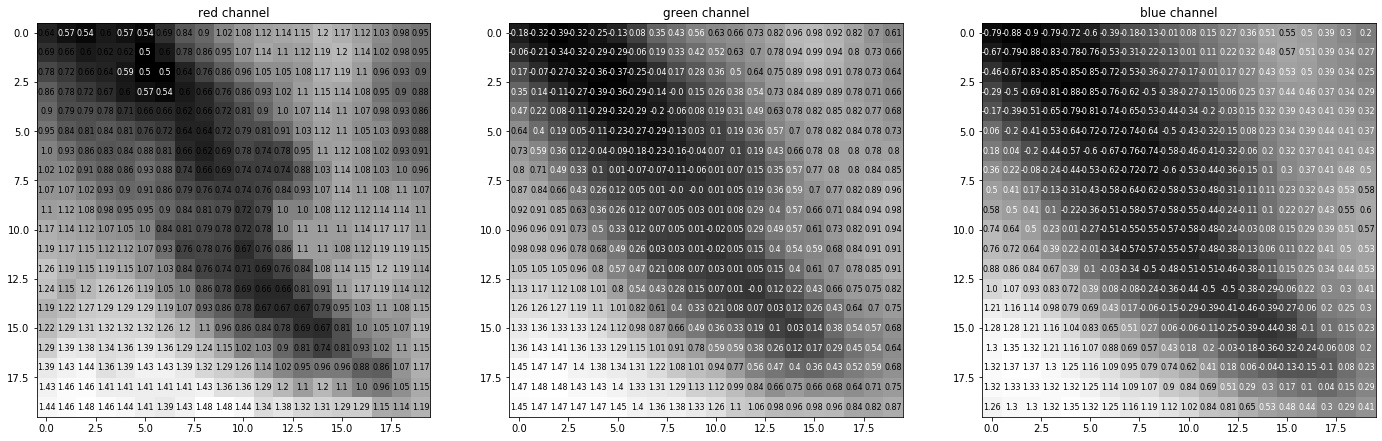

In [ ]:
images = images.numpy() 
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (24, 24)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx][100:120, 100:120]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

Just starting out with the architecture I used for CFAR_10

In [21]:
model = models.densenet121(pretrained=True)

In [22]:
from torch import nn

# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#now replacing the classifier section of the pre-trained model with a classifier of my choice 

classifier = nn.Sequential(
                nn.Linear(1024, 500),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(500, 1),
                nn.Sigmoid())

model.classifier = classifier
print(model.classifier)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=500, out_features=1, bias=True)
  (4): Sigmoid()
)


## Specify Loss Function and Optimiser

In [23]:
import torch.optim as optim

# specify loss function
criterion = nn.BCELoss() # was nn.CrossEntropyLoss() for multi-class examples

# specify optimiser
optimizer = optim.Adam(model.parameters(), lr=0.01)  # This worked much better than SGD
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [ ]:
# number of epochs to train the model
import matplotlib.pyplot as plt

n_epochs = 20 # May need to increase this number to train a final model
print_every = 2

valid_loss_min = np.Inf # track change in validation loss

valid_loss_tracker = np.zeros(n_epochs)
train_loss_tracker = np.zeros(n_epochs)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.squeeze(model(data))     # should be a tensor with torch.size [batch_size,1] if all going well
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.squeeze(model(data))
        # calculate the batch loss, the squeeze and float are used to match up the target dimension and dtype
        loss = criterion(output, target.float())  
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # Store in an array, for later plotting
    train_loss_tracker[epoch-1] = train_loss
    valid_loss_tracker[epoch-1] = valid_loss
    
    # print training/validation statistics 
    
    if epoch%print_every == 0 or epoch == 1:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        if epoch%print_every == 1:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model_pre_pistachio.pt')
        valid_loss_min = valid_loss

# Plot the training and validation losses
epoch = np.arange(1, n_epochs+1)
plt.plot(epoch, valid_loss_tracker, 'r--', label='Validation Loss') 
plt.plot(epoch, train_loss_tracker, 'b-', label='Training Loss')
plt.legend()
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend()
plt.show()

KeyboardInterrupt: 

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_pretrain_cat_dog.pt'))

---
## Test the Trained Network

Use the saved network on some test images.

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = torch.squeeze(model(data))
    # calculate the batch loss
    loss = criterion(output, target.float())
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output scores to predictions, and store as a pytorch float tensor
    pred = torch.FloatTensor([1 if y > 0.5 else 0 for y in output])
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
#images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output scores to predictions
preds = [1 if y > 0.5 else 0 for y in output]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])   
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
    color=("green" if preds[idx]==labels[idx].item() else "red"))

## Useful learning:


- The test set doesn't need to do all the transforms!  It is sensible to treat the train & valid data with one set of transforms, then split up by randomising a set of indices and using train_sampler = SubsetRandomSampler(train_idx), valid_sampler = SubsetRandomSampler(valid_idx) in the dataloaders

- I should figure out a better way to get zipped image folders unzipped onto Gdrive.  To save uploading from slow internet connections.
